# Maintenance Planning
Keywords: scheduling, cbc usage, gdp, disjunctive programming

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))
import pyomo.environ as pyo
import pyomo.gdp as gdp

## Problem statement


A process unit is operating over a maintenance planning horizon from $1$ to $T$ days.  On day $t$ the unit makes a profit $c[t]$ which is known in advance. The unit needs to shut down for $P$ maintenance periods during the planning period.  Once started, a maintenance period takes $M$ days to finish.

Find a maintenance schedule that allows the maximum profit to be produced.

## Modeling with disjunctive constraints

The model is comprised of two sets of the binary variables indexed 1 to $T$. Binary variables $x_t$ correspond to the operating mode of the process unit, with $x_t=1$ indicating the unit is operating on day $t$ and able to earn a profit $c_t$. Binary variable $y_t=1$ indicates the first day of a maintenance period during which the unit is not operating and earning $0$ profit.

### Objective

The planning objective is to maximize profit realized during the days the plant is operational. 

$$
\begin{align*}
\mbox{Profit} & = \max_{x, y} \sum_{t=1}^T c_t x_t
\end{align*}
$$

subject to completing $P$ maintenance periods.  

### Constraints

**Number of planning periods is equal to P.**

Completing $P$ maintenance periods requires a total of $P$ starts.

$$
\begin{align*}
\sum_{t=1}^T y_t &  = P \\
\end{align*}
$$

**No more than one maintenance period can start in any consecutive set of M days.**

No more than one maintenance period can start in any consecutive set of M days.

$$
\begin{align*}
\sum_{s=0}^{M-1}y_{t+s} & \leq 1 \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

This last requirement could be modified if some period of time should occur between maintenance periods.

**The unit must shut down for M days following a maintenance start.**

The final requirement is a disjunctive constraint that says either $y_t = 0$ or the sum $\sum_{s}^{M-1}x_{t+s} = 0$, but not both. Mathematically, this forms a set of constraints reading

$$
\begin{align*}
\left(y_t = 0\right) \lor \left(\sum_{s=0}^{M-1}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

where $\lor$ denotes a disjunction.

Disjunctive constraints of this nature are frequently encountered in scheduling problems. In this particular case, the disjunctive constraints can be replaced by a set of linear inequalities using the Big-M method.

$$
\begin{align*}
\sum_{s=0}^{M-1}x_{t+s} \leq M(1-y_t) \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

In this case, the $M$ appearing on the right-hand side of this constraint happens to be the same as the length of each maintenance period.

## Pyomo solution using the big-M method

### Parameter values

In [2]:
# problem parameters
T = 90        # planning period from 1..T
M = 3         # length of maintenance period
P = 4         # number of maintenance periods

# daily profits
c = {k:np.random.uniform() for k in range(1, T+1)}

### Pyomo model

The disjunctive constraints can be represented directly in Pyomo using the [Generalized Disjunctive Programming](https://pyomo.readthedocs.io/en/latest/modeling_extensions/gdp.html) extension. The GDP extension transforms the disjunctive constraints to an MILP using convex hull and cutting plane methods.

In [3]:
def maintenance_planning_bigm(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T - M + 1)
    m.S = pyo.RangeSet(0, M - 1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)

    # disjunctive constraints
    m.bigm = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.x[t+s] for s in m.S) <= M*(1 - m.y[t]))
    
    return m
   
m = maintenance_planning_bigm(c, T, M, P)
pyo.SolverFactory('cbc').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 41.42942891
  Upper bound: 41.42942891
  Number of objectives: 1
  Number of constraints: 176
  Number of variables: 178
  Number of binary variables: 180
  Number of integer variables: 180
  Number of nonzeros: 90
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.02
  Wallclock time: 0.02
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    

### Display results

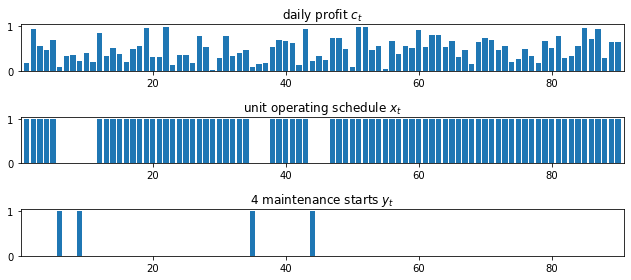

In [4]:

def plot_schedule(m):
    fig,ax = plt.subplots(3,1, figsize=(9,4))
    
    ax[0].bar(m.T, [m.c[t] for t in m.T])
    ax[0].set_title('daily profit $c_t$')
    
    ax[1].bar(m.T, [m.x[t]() for t in m.T], label='normal operation')
    ax[1].set_title('unit operating schedule $x_t$')
    
    ax[2].bar(m.Y, [m.y[t]() for t in m.Y])
    ax[2].set_title(str(P) + ' maintenance starts $y_t$')
    for a in ax:
        a.set_xlim(0.1, len(m.T)+0.9)
        
    plt.tight_layout()

plot_schedule(m)

## Pyomo solution using the generalized disjunctive constraints extension

Disjunctive constraints can be represented directly in Pyomo using the [Generalized Disjunctive Programming](https://pyomo.readthedocs.io/en/latest/modeling_extensions/gdp.html) extension. The advantage of using the extension is that constraints can be transformed to an MILP using alternatives to the big-M, such as convex hull and cutting plane methods.

The following cell replaces the Big-M constraints with disjunctions. Disjunctions are represented by lists of mutually exclusive constraints.

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 41.42942891
  Upper bound: 41.42942891
  Number of objectives: 1
  Number of constraints: 440
  Number of variables: 266
  Number of binary variables: 356
  Number of integer variables: 356
  Number of nonzeros: 90
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.03
  Wallclock time: 0.03
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    

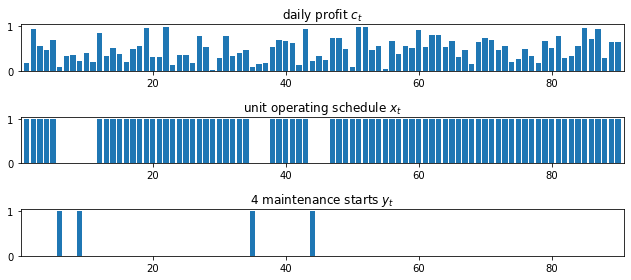

In [5]:
def maintenance_planning_gdp(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T - M + 1)
    m.S = pyo.RangeSet(0, M - 1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, domain=pyo.Binary)
    m.y = pyo.Var(m.T, domain=pyo.Binary)

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)

    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)

    # disjunctive constraints
    m.disj = gdp.Disjunction(m.Y, rule = lambda m, t: [m.y[t]==0, sum(m.x[t+s] for s in m.S)==0])

    # transformation and soluton
    pyo.TransformationFactory('gdp.hull').apply_to(m)
    
    return m

m = maintenance_planning_gdp(c, T, M, P)
pyo.SolverFactory('cbc').solve(m).write()
plot_schedule(m)

## Ramping constraints

Prior to maintenance shutdown, a large processing unit may take some time to safely ramp down from full production. And then require more time to safely ramp back up to full production following maintenance. To provide for ramp-down and ramp-up periods, we modify the problem formation in the following ways.

* The variable denoting unit operation, $x_t$ is changed from a binary variable to a continuous variable $0 \leq x_t \leq 1$ denoting the fraction of total capacity at which the unit is operating on day $t$.

* Two new variable sequences, $0 \leq u_t^+ \leq u_t^{+,\max}$ and $0\leq u_t^- \leq u_t^{-,\max}$, are introduced which denote the fraction increase or decrease in unit capacity to completed on day $t$.

* An additional sequence of equality constraints is introduced relating $x_t$ to $u_t^+$ and $u_t^-$.

$$
\begin{align*}
x_{t} & = x_{t-1} + u^+_t - u^-_t
\end{align*}
$$

We begin the Pyomo model by specifying the constraints, then modifying the Big-M formulation to add the features described above.

In [6]:
upos_max = 0.3334
uneg_max = 0.5000

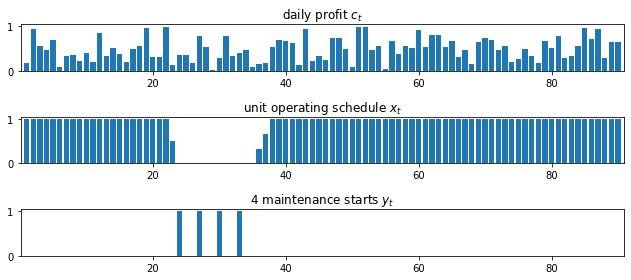

In [7]:
def maintenance_planning_ramp(c, T, M, P):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T - M + 1)
    m.S = pyo.RangeSet(0, M - 1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, bounds=(0, 1))
    m.y = pyo.Var(m.T, domain=pyo.Binary)
    m.upos = pyo.Var(m.T, bounds=(0, upos_max))
    m.uneg = pyo.Var(m.T, bounds=(0, uneg_max))

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)
    
    # ramp constraint
    m.ramp = pyo.Constraint(m.T, rule = lambda m, t: 
         m.x[t] == m.x[t-1] + m.upos[t] - m.uneg[t] if t > 1 else pyo.Constraint.Skip)
      
    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.S) <= 1)
    
    # disjunctive constraints
    m.disj = gdp.Disjunction(m.Y, rule = lambda m, t: [m.y[t]==0, sum(m.x[t+s] for s in m.S)==0])
    
    # transformation and soluton
    pyo.TransformationFactory('gdp.hull').apply_to(m)
    
    return m
  
m = maintenance_planning_ramp(c, T, M, P)
pyo.SolverFactory('cbc').solve(m)
plot_schedule(m)

## Specifying the minimum number of operational days between maintenance periods

Up to this point we have imposed no constraints on the frequency of maintenance periods. Without such constraints, particularly when ramping constraints are imposed, is that maintenance periods will be scheduled back-to-back, which is clearly not a useful result for most situations.

The next revision of the model is to incorporate a requirement that $N$ operational days be scheduled between any maintenance periods. This does allow for maintenance to be postponed until the very end of the planning period. The disjunctive constraints read

$$
\begin{align*}
\left(y_t = 0\right) \lor \left(\sum_{s=0}^{(M + N -1) \wedge (t + s \leq T)}x_{t+s} = 0\right)\qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

where the upper bound on the summation is needed to handle the terminal condition. 

Paradoxically, this is an example where the Big-M method provides a much faster solution.

$$
\begin{align*}
\sum_{s=0}^{(M + N -1) \wedge (t + s \leq T)}x_{t+s} \leq (M+N)(1-y_t) \qquad \forall t = 1, 2, \ldots, T-M+1
\end{align*}
$$

The following cell implements both sets of constraints. 

In [8]:
N = 10  # minimum number of operational days between maintenance periods

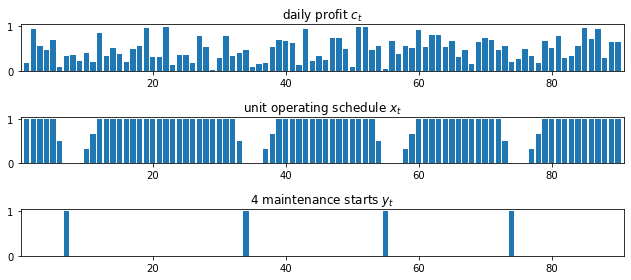

In [9]:
def maintenance_planning_ramp_operational(c, T, M, P, N):
    m = pyo.ConcreteModel()

    m.T = pyo.RangeSet(1, T)
    m.Y = pyo.RangeSet(1, T - M + 1)
    m.S = pyo.RangeSet(0, M - 1)
    m.W = pyo.RangeSet(0, M + N - 1)

    m.c = pyo.Param(m.T, initialize = c)
    m.x = pyo.Var(m.T, bounds=(0, 1))
    m.y = pyo.Var(m.T, domain=pyo.Binary)
    m.upos = pyo.Var(m.T, bounds=(0, upos_max))
    m.uneg = pyo.Var(m.T, bounds=(0, uneg_max))

    # objective
    m.profit = pyo.Objective(expr = sum(m.c[t]*m.x[t] for t in m.T), sense=pyo.maximize)
    
    # ramp constraint
    m.ramp = pyo.Constraint(m.T, rule = lambda m, t: 
         m.x[t] == m.x[t-1] + m.upos[t] - m.uneg[t] if t > 1 else pyo.Constraint.Skip)
      
    # required number P of maintenance starts
    m.sumy = pyo.Constraint(expr = sum(m.y[t] for t in m.Y) == P)

    # no more than one maintenance start in the period of length M
    m.sprd = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.y[t+s] for s in m.W if t + s <= T) <= 1)   
    
    # Choose one or the other the following methods. Comment out the method not used.
    
    # disjunctive constraints, big-M method.
    m.bigm = pyo.Constraint(m.Y, rule = lambda m, t: sum(m.x[t+s] for s in m.S) <= (M+N)*(1 - m.y[t]))
    
    # disjunctive constraints, GDP programming method
    #m.disj = gdp.Disjunction(m.Y, rule = lambda m, t: [m.y[t]==0, sum(m.x[t+s] for s in m.W if t + s <= T)==0])
    #pyo.TransformationFactory('gdp.hull').apply_to(m)
    
    return m

m = maintenance_planning_ramp_operational(c, T, M, P, N)
pyo.SolverFactory('cbc').solve(m)
plot_schedule(m)

## Exercises

1. Rather than specify how many maintenance periods must be accomodated, modify the model so that the process unit can operate no more than $N$ days without a maintenance shutdown.  (Hint. You may to introduce an additional set of binary variables, $z_t$ to denote the start of an operational period.)

2. Do a systematic comparison of the Big-M, Convex Hull, and Cutting Plane techniques for implementing the disjunctive constraints. Your comparison should include a measure of complexity (such as the number of decision variables and constraints in the resulting transformed problems), computational effort, and the effect of solver (such as glpk vs cbc).